<font color=red><h1> 1. Loading data and packages</h1></font>

<font color=green><h2> 1.1 Loading packages</h2></font>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime
from tabulate import tabulate
import plotly.graph_objs as go
import riskfolio as rp
import seaborn as sns
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list
import pyhrp
import warnings
warnings.filterwarnings('ignore')

<font color=green><h2> 1.2 Loading Data</h2></font>

In [3]:
Tickers=['AAPL','AMZN','NVDA','WMT','META','IBM','MSFT']
start_date=datetime.strptime('2015-01-01','%Y-%m-%d').date()
end_date=datetime.strptime('2019-01-01','%Y-%m-%d').date()

Stocks_data=yf.download(Tickers,start_date,end_date)
data_close=Stocks_data['Close']


<font color=green><h2> 1.3 Returns Dynamics Over time</h2></font>

In [24]:
Returns=data_close.pct_change()
Returns.dropna(inplace=True)

Colors=['blue','red','green','olive','purple','cyan','orange']
Trace=list(np.ones(len(Tickers)))
for i in range(len(Tickers)):
  Trace[i] = go.Scatter(x=data_close.index,y=data_close.iloc[:,i],name=data_close.columns[i],line=dict(color=Colors[i], width=2),marker=dict(size=2))

layout = go.Layout(xaxis = dict(title = 'Date'),yaxis = dict(title = 'Adj Close'),template = 'plotly_white' )

fig = go.Figure(data=Trace, layout=layout,)

fig.show()

In [6]:
#Annualizing input parameters
mu=Returns.mean()*252
sigma=Returns.cov()*252

print("Expected Returns")
print(tabulate(pd.DataFrame(mu,columns=['Expected Returns']),headers="keys", tablefmt='fancy_grid'))


print('Covariance Matrix')
print(tabulate(pd.DataFrame(sigma),headers="keys", tablefmt='fancy_grid'))

Expected Returns
╒══════════╤════════════════════╕
│ Ticker   │   Expected Returns │
╞══════════╪════════════════════╡
│ AAPL     │          0.121905  │
├──────────┼────────────────────┤
│ AMZN     │          0.443423  │
├──────────┼────────────────────┤
│ IBM      │         -0.0674568 │
├──────────┼────────────────────┤
│ META     │          0.169232  │
├──────────┼────────────────────┤
│ MSFT     │          0.223566  │
├──────────┼────────────────────┤
│ NVDA     │          0.566565  │
├──────────┼────────────────────┤
│ WMT      │          0.0417281 │
╘══════════╧════════════════════╛
Covariance Matrix
╒══════════╤═══════════╤═══════════╤═══════════╤════════════╤═══════════╤═══════════╤════════════╕
│ Ticker   │      AAPL │      AMZN │       IBM │       META │      MSFT │      NVDA │        WMT │
╞══════════╪═══════════╪═══════════╪═══════════╪════════════╪═══════════╪═══════════╪════════════╡
│ AAPL     │ 0.0599684 │ 0.0360555 │ 0.0192301 │ 0.0316976  │ 0.0333213 │ 0.0414446 │ 0.01

<font color=red><h1> 2. HRP Process</h1></font>

<font color=blue><h2> 2.1 Step1: Hierarchical Tree Clustering</h2></font>

![distance1](distance1.JPG)

In [8]:
def distance(corrij):
    distance_value=np.sqrt(0.5*(1-corrij))
    return(distance_value)

![distance1](distance2.JPG)

In [ ]:
def distance_of_distance(corrij):
    distances=distance(corrij)
    distance_distance_value=pd.DataFrame(index=distances.index,columns=distances.columns)
    for i in distances.index:
        for j in distances.columns:
            distance_distance_value.loc[i,j]=np.sqrt(np.sum((distances.loc[i]-distances.loc[j])**2))

    return(distance_distance_value)

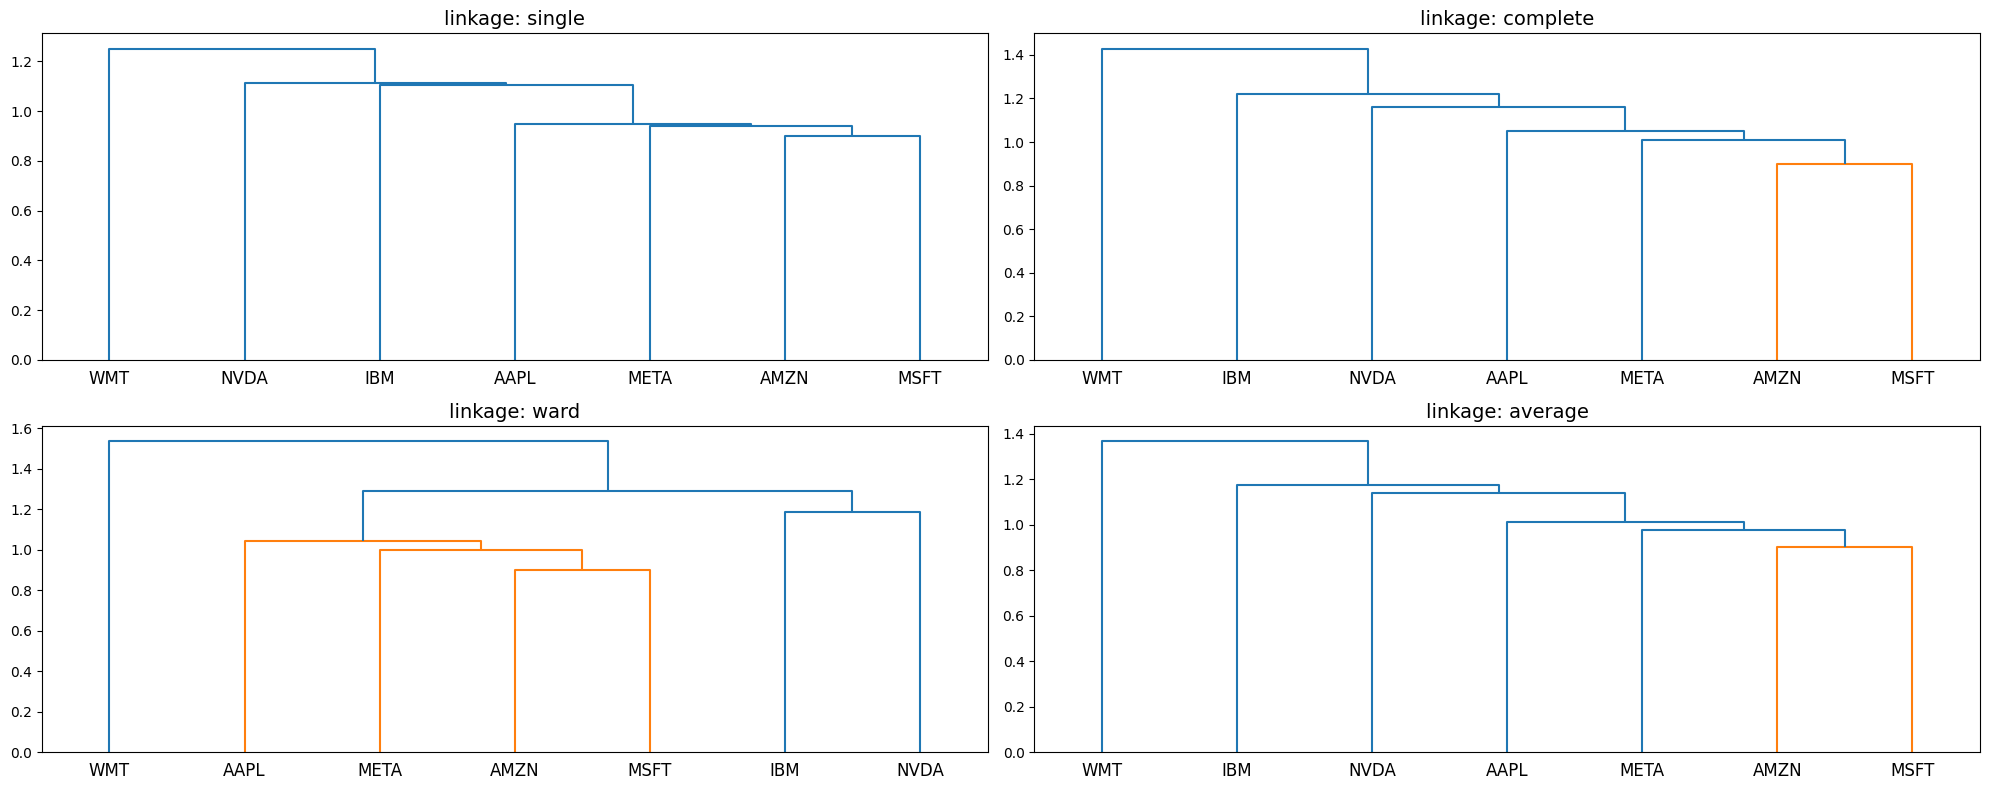

In [ ]:
#list of possible types of linkage
linkage_type=['single','complete','ward','average']



fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 8))


axes = axes.flatten()

for i, method in enumerate(linkage_type):
    linkage_matrix= linkage(distance_of_distance(Returns.corr()), method=method)
    dendrogram(linkage_matrix, labels=data_close.columns, ax=axes[i])
    axes[i].set_title(f'linkage: {method}', fontsize=14)

plt.tight_layout()
plt.show()

<font color=blue><h2> 2.2 Step2: Quasi-Diagonalisation </h2></font>

Text(0.5, 1.0, 'Quasi-Diagonalisation')

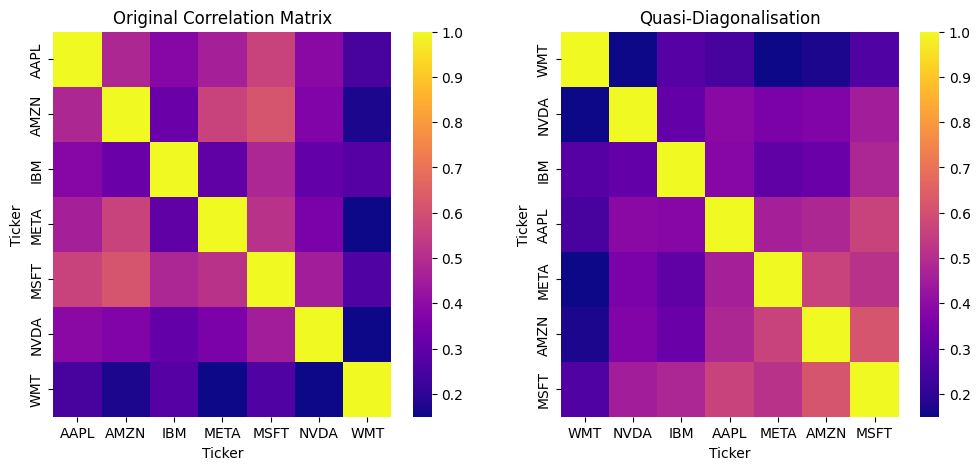

In [11]:
linkage_matrix= linkage(distance_of_distance(Returns.corr()), method='single')


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axes = axes.flatten()

sns.heatmap(Returns.corr(), cmap="plasma", ax=axes[0])
axes[0].set_title('Original Correlation Matrix')

Quasi_diagona=Returns.iloc[:,leaves_list(linkage_matrix)].corr()
sns.heatmap(Quasi_diagona,cmap="plasma", ax=axes[1])
axes[1].set_title('Quasi-Diagonalisation')


<font color=blue><h2> 2.3 Step3: Weight allocation </h2></font>

<Axes: title={'center': 'Hierarchical risk parity'}>

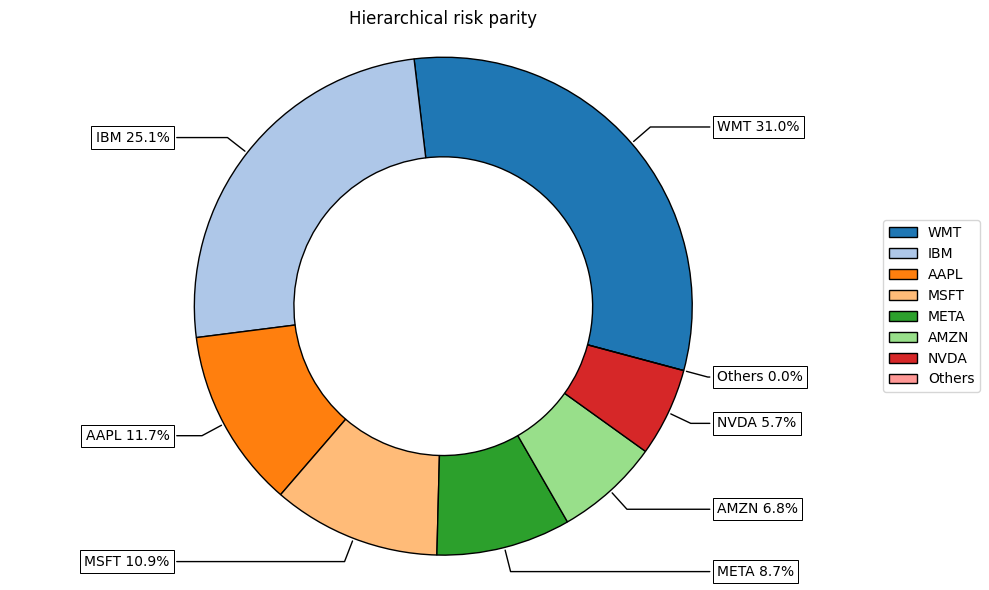

In [28]:
port = rp.HCPortfolio(returns=Returns)
weights = port.optimization(model='HRP',codependence='pearson',rm='MV',rf=0,linkage='single',leaf_order=False)
rp.plot_pie(w=weights, title='Hierarchical risk parity', others=0.05, nrow=25, cmap = "tab20",height=6, width=10, ax=None)